In [1]:
import os
import json
from PIL import Image
import torch
from torch.utils.data import Dataset

In [2]:
def _load_coco(path):
    with open(path, "r") as f:
        return json.load(f)

In [3]:
def _build_cat_mapping(train_coco):
    """
    Build a stable mapping from category_id -> class_index using TRAIN split only.
    This avoids label mismatch between train/val if they list categories differently.
    """
    cat_ids = sorted({c["id"] for c in train_coco["categories"]})
    catid_to_idx = {cid: i for i, cid in enumerate(cat_ids)}
    return catid_to_idx

In [4]:
class CocoObjectCropClassification(Dataset):
    """
    Each COCO annotation becomes one classification sample:
      - load image
      - crop bbox
      - return (crop, label_index)
    """
    def __init__(self, images_dir, coco_json_path, catid_to_idx, transform=None):
        self.images_dir = images_dir
        self.transform = transform
        self.catid_to_idx = catid_to_idx

        coco = _load_coco(coco_json_path)

        self.img_by_id = {img["id"]: img for img in coco["images"]}

        # Build samples from annotations
        self.samples = []
        bad_category = 0

        for ann in coco["annotations"]:
            cid = ann["category_id"]
            if cid not in self.catid_to_idx:
                bad_category += 1
                continue

            img_info = self.img_by_id.get(ann["image_id"])
            if img_info is None:
                continue

            self.samples.append({
                "file_name": img_info["file_name"],
                "bbox": ann["bbox"],  # [x,y,w,h]
                "label": self.catid_to_idx[cid],
            })

        if bad_category > 0:
            print(f"[WARN] Skipped {bad_category} annotations with category_id not in train mapping.")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        s = self.samples[idx]
        img_path = os.path.join(self.images_dir, s["file_name"])

        image = Image.open(img_path).convert("RGB")

        x, y, w, h = s["bbox"]
        left   = int(round(x))
        top    = int(round(y))
        right  = int(round(x + w))
        bottom = int(round(y + h))

        # Clamp to image bounds (prevents crashes on weird bboxes)
        W, H = image.size
        left = max(0, min(left, W - 1))
        top = max(0, min(top, H - 1))
        right = max(left + 1, min(right, W))
        bottom = max(top + 1, min(bottom, H))

        crop = image.crop((left, top, right, bottom))
        label = s["label"]

        if self.transform:
            crop = self.transform(crop)

        return crop, label

In [5]:
from torchvision import transforms
from torch.utils.data import DataLoader

root = "./coco"
train_dir = os.path.join(root, "train")
val_dir   = os.path.join(root, "valid")

train_json = os.path.join(train_dir, "_annotations.coco.json")
val_json   = os.path.join(val_dir, "_annotations.coco.json")

# Define transforms for classification model
train_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

val_tf = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Build mapping from TRAIN categories
train_coco = _load_coco(train_json)
catid_to_idx = _build_cat_mapping(train_coco)
num_classes = len(catid_to_idx)

train_ds = CocoObjectCropClassification(train_dir, train_json, catid_to_idx, transform=train_tf)
val_ds   = CocoObjectCropClassification(val_dir,   val_json,   catid_to_idx, transform=val_tf)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

print("Train samples:", len(train_ds))
print("Val samples:", len(val_ds))
print("Num classes:", len(catid_to_idx))

Train samples: 2606
Val samples: 755
Num classes: 42


In [6]:
import torch.nn as nn
from simclr import SimCLR
from simclr.modules import get_resnet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet_name = "resnet50"
projection_dim = 64

encoder = get_resnet(resnet_name, pretrained=False)
n_features = encoder.fc.in_features

simclr_model = SimCLR(encoder, projection_dim, n_features)

ckpt_path = "./checkpoint/checkpoint_100.tar"
simclr_model.load_state_dict(torch.load(ckpt_path, map_location=device))
simclr_model = simclr_model.to(device)


simclr_model.train()

/home/917160535/miniconda3/envs/gioConda/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/917160535/miniconda3/envs/gioConda/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


SimCLR(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (

In [7]:
class SimCLRFinetuneClassifier(nn.Module):
    def __init__(self, simclr_model, num_classes):
        super().__init__()
        self.simclr = simclr_model
        self.classifier = nn.Linear(self.simclr.n_features, num_classes)

    def forward(self, x):
        # SimCLR forward expects (x_i, x_j). For supervised fine-tune, you can pass x twice.
        h, _, _, _ = self.simclr(x, x)
        logits = self.classifier(h)
        return logits

model = SimCLRFinetuneClassifier(simclr_model, num_classes).to(device)


In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-4)

def run_epoch(loader, training=True):
    model.train(training)
    total_loss, total_correct, total_n = 0.0, 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        if training:
            optimizer.zero_grad()

        logits = model(x)
        loss = criterion(logits, y)

        if training:
            loss.backward()
            optimizer.step()

        total_loss += loss.item() * y.size(0)
        total_correct += (logits.argmax(1) == y).sum().item()
        total_n += y.size(0)

    return total_loss / total_n, total_correct / total_n

train_losses = []
val_losses = []

for epoch in range(20):
    tr_loss, tr_acc = run_epoch(train_loader, training=True)
    va_loss, va_acc = run_epoch(val_loader, training=False)

    train_losses.append(tr_loss)
    val_losses.append(va_loss)
    
    print(f"Epoch {epoch:02d} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f}")


Epoch 00 | train loss 1.4073 acc 0.6784 | val loss 0.5091 acc 0.8609
Epoch 01 | train loss 0.4112 acc 0.8983 | val loss 0.1708 acc 0.9775
Epoch 02 | train loss 0.1713 acc 0.9662 | val loss 0.0766 acc 0.9801
Epoch 03 | train loss 0.0817 acc 0.9881 | val loss 0.0592 acc 0.9894
Epoch 04 | train loss 0.0535 acc 0.9896 | val loss 0.0455 acc 0.9881
Epoch 05 | train loss 0.0354 acc 0.9939 | val loss 0.0272 acc 0.9960
Epoch 06 | train loss 0.0212 acc 0.9973 | val loss 0.0288 acc 0.9947
Epoch 07 | train loss 0.0223 acc 0.9962 | val loss 0.0228 acc 0.9974
Epoch 08 | train loss 0.0133 acc 0.9988 | val loss 0.0223 acc 0.9974
Epoch 09 | train loss 0.0091 acc 0.9988 | val loss 0.0388 acc 0.9934
Epoch 10 | train loss 0.0097 acc 0.9988 | val loss 0.0244 acc 0.9974
Epoch 11 | train loss 0.0040 acc 1.0000 | val loss 0.0234 acc 0.9974
Epoch 12 | train loss 0.0027 acc 1.0000 | val loss 0.0225 acc 0.9974
Epoch 13 | train loss 0.0025 acc 1.0000 | val loss 0.0225 acc 0.9960
Epoch 14 | train loss 0.0022 acc 1

In [9]:
save_dir = "./finetuned_model"
os.makedirs(save_dir, exist_ok=True)


checkpoint_path = os.path.join(save_dir, f"simclr_finetuned_epoch_{epoch}.pt")

torch.save({
    "epoch": epoch,
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    "num_classes": num_classes,
    "catid_to_idx": catid_to_idx,
}, checkpoint_path)

print(f"Saved checkpoint to {checkpoint_path}")

Saved checkpoint to ./finetuned_model/simclr_finetuned_epoch_19.pt


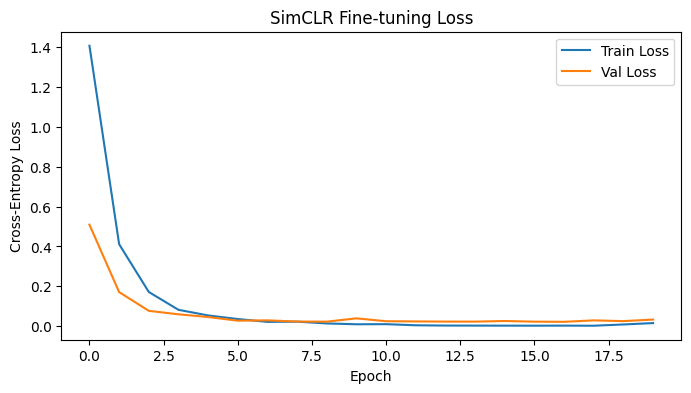

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.title("SimCLR Fine-tuning Loss")
plt.legend()
plt.show()